# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


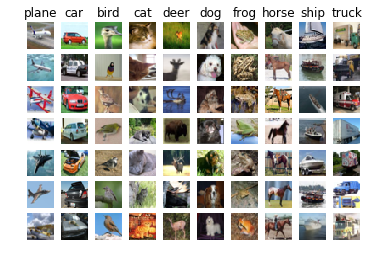

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


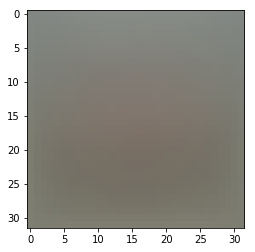

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.717878


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
print("Add Regularization Item:")
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.459945 analytic: 1.459945, relative error: 4.203789e-11
numerical: -1.632884 analytic: -1.632884, relative error: 8.849528e-11
numerical: -4.895523 analytic: -4.895523, relative error: 4.165737e-12
numerical: 1.036294 analytic: 1.036294, relative error: 2.259680e-11
numerical: 0.053006 analytic: 0.053006, relative error: 6.932305e-09
numerical: -0.896733 analytic: -0.896733, relative error: 7.200073e-11
numerical: 3.088258 analytic: 3.088258, relative error: 5.632667e-11
numerical: 7.759296 analytic: 7.759296, relative error: 5.668947e-12
numerical: -3.515996 analytic: -3.515996, relative error: 9.266332e-12
numerical: 8.078049 analytic: 8.078049, relative error: 7.132432e-13
Add Regularization Item:
numerical: 20.033339 analytic: 20.033339, relative error: 2.219633e-11
numerical: 1.558799 analytic: 1.558799, relative error: 1.541728e-11
numerical: -11.760224 analytic: -11.760224, relative error: 1.807869e-11
numerical: -21.384562 analytic: -21.384562, relative error: 8.28

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [21]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.717878e+00 computed in 0.085128s
Vectorized loss: 8.717878e+00 computed in 0.037064s
difference: 0.000000


In [22]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.084127s
Vectorized loss and gradient: computed in 0.007019s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [29]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.238277
iteration 100 / 1500: loss 288.214177
iteration 200 / 1500: loss 108.333935
iteration 300 / 1500: loss 42.864130
iteration 400 / 1500: loss 18.621687
iteration 500 / 1500: loss 10.460011
iteration 600 / 1500: loss 7.055214
iteration 700 / 1500: loss 5.749315
iteration 800 / 1500: loss 6.020106
iteration 900 / 1500: loss 5.596325
iteration 1000 / 1500: loss 5.077951
iteration 1100 / 1500: loss 5.483223
iteration 1200 / 1500: loss 4.889188
iteration 1300 / 1500: loss 4.975227
iteration 1400 / 1500: loss 5.603475
That took 8.702111s


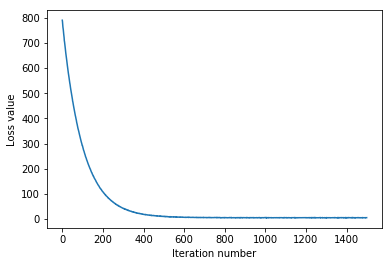

In [30]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [39]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370939
validation accuracy: 0.373000


In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################


for lr in np.linspace(learning_rates[0],learning_rates[1],10):
    for reg in np.linspace(regularization_strengths[0],regularization_strengths[1],10):
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg,num_iters=1500, verbose=True)
        train_accuracy = np.mean(y_train == svm.predict(X_train))
        val_accuracy = np.mean(y_val == svm.predict(X_val))
        if val_accuracy>best_val:
            best_svm = svm
            best_val = val_accuracy
            results[(lr,reg)] = (train_accuracy,val_accuracy)
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 786.275451
iteration 100 / 1500: loss 287.299728
iteration 200 / 1500: loss 108.403245
iteration 300 / 1500: loss 42.742085
iteration 400 / 1500: loss 19.024134
iteration 500 / 1500: loss 11.212031
iteration 600 / 1500: loss 7.271852
iteration 700 / 1500: loss 5.533953
iteration 800 / 1500: loss 5.743342
iteration 900 / 1500: loss 5.264350
iteration 1000 / 1500: loss 5.134322
iteration 1100 / 1500: loss 5.389272
iteration 1200 / 1500: loss 5.165761
iteration 1300 / 1500: loss 5.208168
iteration 1400 / 1500: loss 4.843741
iteration 0 / 1500: loss 882.874451
iteration 100 / 1500: loss 286.961810
iteration 200 / 1500: loss 97.502176
iteration 300 / 1500: loss 34.919670
iteration 400 / 1500: loss 15.028460
iteration 500 / 1500: loss 8.447101
iteration 600 / 1500: loss 6.061799
iteration 700 / 1500: loss 5.328153
iteration 800 / 1500: loss 5.705302
iteration 900 / 1500: loss 5.181982
iteration 1000 / 1500: loss 5.896202
iteration 1100 / 1500: loss 5.824714
iteration

iteration 1300 / 1500: loss 17.149094
iteration 1400 / 1500: loss 34.205703
iteration 0 / 1500: loss 1215.322443
iteration 100 / 1500: loss 37.269382
iteration 200 / 1500: loss 32.321771
iteration 300 / 1500: loss 27.512811
iteration 400 / 1500: loss 22.575404
iteration 500 / 1500: loss 20.924018
iteration 600 / 1500: loss 33.792741
iteration 700 / 1500: loss 21.431913
iteration 800 / 1500: loss 31.605753
iteration 900 / 1500: loss 32.931018
iteration 1000 / 1500: loss 46.393362
iteration 1100 / 1500: loss 35.822304
iteration 1200 / 1500: loss 24.583050
iteration 1300 / 1500: loss 49.938737
iteration 1400 / 1500: loss 34.306712
iteration 0 / 1500: loss 1320.835347
iteration 100 / 1500: loss 22.307998
iteration 200 / 1500: loss 30.722464
iteration 300 / 1500: loss 32.893083
iteration 400 / 1500: loss 32.746520
iteration 500 / 1500: loss 33.216488
iteration 600 / 1500: loss 30.742503
iteration 700 / 1500: loss 38.864394
iteration 800 / 1500: loss 37.948683
iteration 900 / 1500: loss 39.7

iteration 600 / 1500: loss 162.294563
iteration 700 / 1500: loss 181.322146
iteration 800 / 1500: loss 177.131149
iteration 900 / 1500: loss 170.345670
iteration 1000 / 1500: loss 185.873923
iteration 1100 / 1500: loss 154.915593
iteration 1200 / 1500: loss 147.574858
iteration 1300 / 1500: loss 176.209420
iteration 1400 / 1500: loss 126.577837
iteration 0 / 1500: loss 790.798908
iteration 100 / 1500: loss 167.488848
iteration 200 / 1500: loss 123.661939
iteration 300 / 1500: loss 168.287651
iteration 400 / 1500: loss 135.104574
iteration 500 / 1500: loss 141.997156
iteration 600 / 1500: loss 238.394437
iteration 700 / 1500: loss 173.819001
iteration 800 / 1500: loss 179.616618
iteration 900 / 1500: loss 169.040503
iteration 1000 / 1500: loss 164.747115
iteration 1100 / 1500: loss 142.411838
iteration 1200 / 1500: loss 137.981528
iteration 1300 / 1500: loss 142.203412
iteration 1400 / 1500: loss 198.677858
iteration 0 / 1500: loss 884.473794
iteration 100 / 1500: loss 205.054504
iterat

iteration 1000 / 1500: loss 944.722813
iteration 1100 / 1500: loss 861.882548
iteration 1200 / 1500: loss 1020.847070
iteration 1300 / 1500: loss 872.980260
iteration 1400 / 1500: loss 885.905483
iteration 0 / 1500: loss 1151.149599
iteration 100 / 1500: loss 1425.116568
iteration 200 / 1500: loss 1375.933413
iteration 300 / 1500: loss 1544.857530
iteration 400 / 1500: loss 1609.806228
iteration 500 / 1500: loss 1575.716047
iteration 600 / 1500: loss 1585.163738
iteration 700 / 1500: loss 1603.191338
iteration 800 / 1500: loss 1385.185938
iteration 900 / 1500: loss 1520.273935
iteration 1000 / 1500: loss 1361.564977
iteration 1100 / 1500: loss 1584.255428
iteration 1200 / 1500: loss 1451.152337
iteration 1300 / 1500: loss 1805.186707
iteration 1400 / 1500: loss 1672.466543
iteration 0 / 1500: loss 1231.762063
iteration 100 / 1500: loss 2887.267776
iteration 200 / 1500: loss 2938.230622
iteration 300 / 1500: loss 3090.016603
iteration 400 / 1500: loss 2847.647713
iteration 500 / 1500: l

iteration 1300 / 1500: loss 2855.490742
iteration 1400 / 1500: loss 3244.513697
iteration 0 / 1500: loss 1036.139509
iteration 100 / 1500: loss 10806.262473
iteration 200 / 1500: loss 11272.014788
iteration 300 / 1500: loss 10937.674924
iteration 400 / 1500: loss 12387.962542
iteration 500 / 1500: loss 11428.151107
iteration 600 / 1500: loss 12091.555783
iteration 700 / 1500: loss 11759.107277
iteration 800 / 1500: loss 12376.582216
iteration 900 / 1500: loss 11434.239874
iteration 1000 / 1500: loss 11680.131574
iteration 1100 / 1500: loss 11706.637044
iteration 1200 / 1500: loss 11558.431932
iteration 1300 / 1500: loss 12671.241781
iteration 1400 / 1500: loss 12262.669635
iteration 0 / 1500: loss 1123.525472
iteration 100 / 1500: loss 6109832.940348
iteration 200 / 1500: loss 75781101.754727
iteration 300 / 1500: loss 604068113.329655
iteration 400 / 1500: loss 4218583934.099197
iteration 500 / 1500: loss 28112063184.480675
iteration 600 / 1500: loss 184100984896.072418
iteration 700 

C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:77: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margin[margin>0])/X.shape[0] + reg * np.sum(W * W)
f:\python3.6\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


iteration 1300 / 1500: loss inf


C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:77: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margin[margin>0])/X.shape[0] + reg * np.sum(W * W)


iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1385.633038
iteration 100 / 1500: loss 10414914854889445783310132684284493824.000000
iteration 200 / 1500: loss 46057555709786358537965914697937881611048235828035758085801666452389888.000000
iteration 300 / 1500: loss 203678903525956072495533719834430733003331618411649144263742132669649457171444505519704472190790225887232.000000
iteration 400 / 1500: loss 900722912933934275445921812698858990542377062776349392997968953595065828476931505875529944020516149806766206777777315149799267512229036032.000000
iteration 500 / 1500: loss 3983239068158093980007351394247251993722100566157765697272738041260242835383029642875109173173085967140332824711558834186600331548820956425774469249421882639520304147202048.000000
iteration 600 / 1500: loss 1761495488376091162870450985985815364147314309614020478517101792675074625688998114193754977803579236005800934649675690729261570052693144281585874662243386659038089855332601605168286139369558900933461121433

C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:75: RuntimeWarning: overflow encountered in subtract
  margin = scores - correct_class_score + 1
C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:88: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:75: RuntimeWarning: invalid value encountered in subtract
  margin = scores - correct_class_score + 1
C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:77: RuntimeWarning: invalid value encountered in greater
  loss = np.sum(margin[margin>0])/X.shape[0] + reg * np.sum(W * W)
C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:82: RuntimeWarning: invalid value encountered in greater
  margin[margin>0] = 1
C:\Users\Rubbish\Desktop\cs231n\assignment1\cs231n\classifiers\linear_svm.py:83: RuntimeWarning: invalid value encountered in less_equal
  

iteration 0 / 1500: loss 1571.188881
iteration 100 / 1500: loss 317684886842723222003378462414535406164662838710239232.000000
iteration 200 / 1500: loss 49472910015274943009164095546424302831480899903210350388681561384652636145583830389900664314281051815936.000000
iteration 300 / 1500: loss 7704391762870396456372938276704450493617461645180937814840048043853240449692370305425144790941906568800239301080475738422057670168226832428753272266817536.000000
iteration 400 / 1500: loss 1199801111708576088034085761067023807961886460028604042748921796258998554287973763068337642736524114064949142775168305771876453452528388842801752904403875307110279373668861459275098569556979720647799209984.000000
iteration 500 / 1500: loss 186844432625375409941525284783025408326679337792778174887062908159474664347250827784443136908143496183730926256141377345558023326988526976680104464967590994431103386415122783416544224485798400011562311563407889475789554310515816282989584478797024850870272.000000
iteration 600 / 

iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1225.318235
iteration 100 / 1500: loss 80687713468085610601876832524979329319305216.000000
iteration 200 / 1500: loss 2944617774712512317185936443180273445337686311522115210620213628975969038492860678144.000000
iteration 300 / 1500: loss 107460894186602745494706469883254576597979754618759622693689394036264794064435295309136432052993476119658278984023266646032384.000000
iteration 400 / 1500: loss 3921678351110159813919330992665907317237899267358252974275127035367896046316094177723278001449785679326013153588866290020242500817927166882260627916881908597801353216.000000
iteration 500 / 1500: loss 143117747213790464357512253476928791526826866120578619282488372215908385515932019275627408102977382405477334567164148543454750845290260681176596139931131274448135775886384239181638695571362526169907410763776.000000
iteration 600 / 1500: loss 52229

iteration 600 / 1500: loss 16961395354015817940396391840858233947256342261347961638238552115871447308088377344.000000
iteration 700 / 1500: loss 177984624627151752575139288331713001519799720024533717059582593478708202490180934269950928879616.000000
iteration 800 / 1500: loss 1867683993119577616853616106899806690826200737590163929885853737491306817853171696688431157267340335310176256.000000
iteration 900 / 1500: loss 19598566479898929332136156648311868923324452655149739384800910548851549835921571728086811159342740791660905388050229493760.000000
iteration 1000 / 1500: loss 205657814427938858795678389093808498003407992676288857262626406087804777941755560984637322793684488760109316246805863826980857423331328.000000
iteration 1100 / 1500: loss 2158072973278740417146368635826087903971835372833355905899445915731692676715857834802776179365576045067355312455289351056574878001052524363321966592.000000
iteration 1200 / 1500: loss 2264576705218280181738824684461203777733128115952450722099818094610

iteration 400 / 1500: loss 61567555132437457193129935075510380782699946155712510394063754384148738489898963509002261128920894517833457874431109694955806628656012691975611053535885656056026500624658056163108132732164371076888860711461183445840544352355519243650373628639238304677033122609584162982912772142006272.000000
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1404.561281
iteration 100 / 1500: loss 2230068349971500188682181221562146142988318944128824324673317051822581384029929472.000000
iteration 200 / 1500: loss 3102686664084669686794768649710414668373811969351910169129040293723189713242514481812762545568498357517647579751558685701195671499753507803724976702760022966272.000000
iteration 300 / 1

iteration 200 / 1500: loss 12979911745769318542628063411133038428846013018650476158899849719555095424392319187255050868097024.000000
iteration 300 / 1500: loss 1131331410107598782840547737047591809463663998243036037734965761873794449142006295111808641814311026253683288585868655951446770614830095969288192.000000
iteration 400 / 1500: loss 98607046377894151423548766582743124070220620263451617795306834700089818171706574010687649668414664392085307025303300287143737804437251642528521672725816224931267599923078230693319428110548992.000000
iteration 500 / 1500: loss 8594607652984190430813379227632359752967505399639883228439132681834277732070153716889279829419015289065421419729955945306767839152232366077350383444748879729209940287685903355874476804553392054841539722134198816611377543223643099635908608.000000
iteration 600 / 1500: loss 74910752752547795986188715052968459030865434367490715894973816147083326015003436182758143540604657897073643448072477065610240236710284716367233753044810863503865

iteration 200 / 1500: loss 135533496990320996823352604957717073766730703289721841949045223280220754945257982839420800157906530563529677148301024564709098268830239120941407304598932991367846186714350669954480827737997303920242243060682687640502272.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 800.103855
iteration 100 / 1500: loss 422449990754937630674724692633581518848.000000
iteration 200 / 1500: loss 69827600103114210945786692342969015765195115766179518419695515897339838464.000000
iteration 300 / 1500: loss 11541943053299603884953414552377573198675331906001674736125015942296309779472346188366629870260296836924309504.000000
itera

iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1290.553553
iteration 100 / 1500: loss 19693990919483719574198956429874003410172489640922804938796811784178660727794371485126232633885109256192.000000
iteration 200 / 1500: loss 259898544398865113246069537352182145807939825415354048004128019560688311468289676017552233344909082314778738131933422940056524045088817136657618730685435064328756932492138540146512903180101538218273406976.000000
iteration 300 / 1500: loss 3429840790361226918172853968859590382591165837666822252487050809112966611236845245599936912661983374387737816322433725992441144387715804695633745137024878963858674700994209486042776788712059781668330232292700412526612886935186668975008655855965792927642127647834928991962523729073324838628749350530973696.000000
iteration 400 / 1500: lo

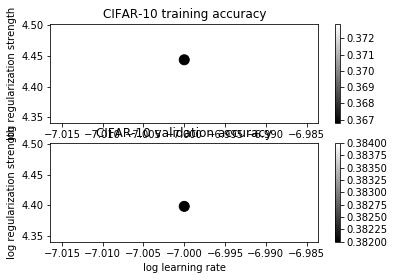

In [44]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [45]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.352000


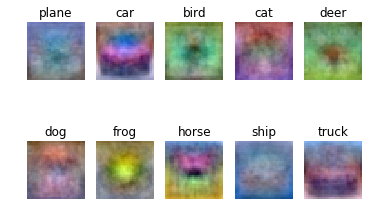

In [46]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*